In [1]:
import numpy as np
import random
from math import floor

In [2]:

MIN_SIZE = 2
MAX_SIZE = 10



In [3]:
#Function to assert the builded grid is solvable
def is_solvable(grid):
    flat_grid = grid.flatten() 
    
    inversions = 0
    for i in range(len(flat_grid)):
        for j in range(i + 1, len(flat_grid)):
            if flat_grid[j] and flat_grid[i] and flat_grid[i] > flat_grid[j]:
                inversions += 1
    return inversions % 2 == 0

def build_line(start_symb, stop_symb, sep_symb, line):
    return '\n%s%s%s\n' % (start_symb, sep_symb.join(line), stop_symb)

In [4]:
# State : Correspond a la grid
# Actions: Dé deplacer :
#0: dé en haut
#1: dé a gauche
#2: dé en bas
#3: dé à droite

class Grid :
    def __init__(self,size=3) -> None:
        assert size>=MIN_SIZE and size <= MAX_SIZE
        self.size=size

        while True:
            grid=list(range(size**2))
            random.shuffle(grid)
            grid=np.asarray(grid).reshape(size, size)
            if is_solvable(grid):break
        self.state=grid


    def take_action(self,action):
      i, j = np.where(self.state == 0)
      if len(i) > 0 and len(j) > 0:
        i = i[0]
        j = j[0]
        if action == 0:
            if i > 0:
                self.state[i][j], self.state[i-1][j] = self.state[i-1][j], self.state[i][j]
        elif action == 2:
            if i < self.size-1:
                self.state[i][j], self.state[i+1][j] = self.state[i+1][j], self.state[i][j]
        elif action ==1:
            if j > 0:
                self.state[i][j], self.state[i][j-1] = self.state[i][j-1], self.state[i][j]
        elif action == 3:
            if j < self.size-1:
                self.state[i][j], self.state[i][j+1] = self.state[i][j+1], self.state[i][j]

    def is_finish(self):
        ended_grid=[i for i in range(1,self.size**2)]
        ended_grid.append(0)
        return np.array_equal(
            self.state,
            np.asarray(ended_grid).reshape(self.size,self.size)
            )
    
    def get_possible_actions(self):
        """return the possible actions"""
        actions=[i for i in range(0,4)]
        pos_empty=self.get_empty_position()
        if pos_empty[0]==0 : actions.remove(0)
        elif pos_empty[0]==(self.size-1):actions.remove(2)
        if pos_empty[1]==0:actions.remove(1)
        elif pos_empty[1]==(self.size-1):actions.remove(3)
        return  actions
    
    def get_empty_position(self)->tuple:
        """Return the position od the tuple"""
        return floor(np.argmin(self.state)/self.size),np.argmin(self.state)%self.size

    def get_good_place(self):
      ended_grid=[i for i in range(1,self.size**2)]
      ended_grid.append(0)
      return (np.asarray(ended_grid).reshape(self.size,self.size) == self.state ).sum()



    def __str__(self) -> str:
        """Renderer"""
        tile_line = np.full(self.size, '─' * 4).tolist()
        horizontal_line = build_line('├', '┤', '┼', tile_line)
        first_horizontal_line = build_line('┌', '┐', '┬', tile_line)
        last_horizontal_line = build_line('└', '┘', '┴', tile_line)
        grid_to_show = first_horizontal_line
        for count, row in enumerate(self.state):
            grid_to_show += '│'
            for tile in row:
                if tile == 0:
                    tile = '  '
                grid_to_show += ' %s │' % '{0:>2}'.format(tile)
            if not count == self.size - 1:
                grid_to_show += horizontal_line
        grid_to_show += last_horizontal_line
        grid_to_show+=f"\n Possible actions: {self.get_possible_actions()}"
        return grid_to_show
        
    

In [5]:
grid=Grid(size=3)
print(grid.state)
grid.is_finish()

[[1 4 0]
 [3 6 2]
 [5 8 7]]


False

In [6]:
import numpy as np

class Qlearning:
    def __init__(self, actions, alpha=0.1, gamma=0.9, epsilon=0.1,size=2):
        self.Q = {}
        self.actions = actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.size=size**2

    def get_Q(self, state, action):
        if tuple(state.reshape(self.size)) not in self.Q:
            self.Q[tuple(state.reshape(self.size))] = np.zeros(len(self.actions))
        return self.Q[tuple(state.reshape(self.size))][action]

    def choose_action(self, state,possible_actions):
        if np.random.uniform() < self.epsilon:
            # Choose a random action
            return np.random.choice(possible_actions)
        else:
            # Choose the action with the highest Q-value
            q_values = [self.get_Q(state, a) for a in possible_actions]
            max_q = max(q_values)
            if q_values.count(max_q) > 1:
                # Multiple actions have the same highest Q-value, choose one randomly
                
                return possible_actions[np.random.choice(np.flatnonzero(np.array(q_values) == np.array(q_values).max()))]
            else:
                return possible_actions[np.argmax(q_values)]

    def update(self, state, action, reward, next_state):
        old_Q = self.get_Q(state, action)
        next_max_Q = max([self.get_Q(next_state, a) for a in self.actions])
        new_Q = old_Q + self.alpha * (reward + self.gamma * next_max_Q - old_Q)
        #print(action,reward)
        self.Q[tuple(state.reshape(self.size))][action] = new_Q
        #print(self.Q)


In [7]:
class Game:
  
  def __init__(self,size=2) -> None:
      self.grid=Grid(size)

      self.end=False
      self.round=0
      self.reward=0
      self.sum_reward=0
      self.actions=[]# list of all actions done in the game
      self.last_good=0
      self.number_good_place=0
      self.ligne=0
      self.col=0
      ended_grid=[i for i in range(1,self.grid.size**2)]
      ended_grid.append(0)
      self.ended_grid = np.asarray(ended_grid).reshape(self.grid.size,self.grid.size)
      self.all_grid=[]

  def play_round(self,action):
      """function_agent : fonction de choix de l'agent"""
      reward=-1
      last_ligne=self.ligne
      last_col=self.col

      self.grid.take_action(action)
      if self.grid.is_finish():
        self.end = True
        reward += 50000000
      
        if (self.grid.state[0] == self.ended_grid[0]).all():
          if self.ligne < 1:
            reward +=1200
          self.ligne=1
          if (self.grid.state[1] == self.ended_grid[1]).all():
            if self.ligne < 2:
              reward+=2000
            self.ligne=2
        else:
          self.ligne=0
        #if self.ligne < last_ligne:
         # reward -= 300 # He loose if he delete a row but just a litle because he can get stuck



        if (self.grid.state[:,:1] == self.ended_grid[:,:1]).all():
          if self.col < 1:
            reward +=1200
          self.col=1
          if (self.grid.state[:,1:2] == self.ended_grid[:,1:2]).all():
            if self.col < 2:
              reward+=2000
            self.col=2
        else:
          self.col=0
        #if self.col < last_col:
        #  reward -= 300 

      if self.grid.get_good_place() == self.number_good_place + 1:
        reward += 100
        self.last_good += 1
        self.number_good_place += 1
      elif self.grid.get_good_place() <= self.number_good_place:
        reward -= 10

      return reward,self.grid.state,action


  def play_game(self,qlearner,stop=100000, print_game=False):

      while not self.end:
          state=self.grid.state.copy()
          action = qlearner.choose_action(state,self.grid.get_possible_actions())

          reward,next_state,action=self.play_round(action)
          
          qlearner.update(state, action, reward, next_state)

          self.sum_reward+=reward
          if self.round > stop:
            return False
            break
          self.round+=1
          if print_game :
            print(f"round: {self.round}")
            print(f"action: {action}")
            print(f"Sum of reward: {self.sum_reward}")
            print(self.grid)
            state=self.grid.state.copy()
            self.all_grid.append(state)

      return True

  def __str__(self):
      game_to_show=f"---- {self.round} ----------\n"
      game_to_show+=self.grid.__str__()
      game_to_show+=f"\nReward Round{self.reward} \nReward cum:{self.sum_reward}"
      return game_to_show

In [8]:
size=3
qlearner = Qlearning(actions=[0, 1, 2, 3],size=size)
qlearner.epsilon=0.7

Load the model


In [9]:
model_weight = np.load("QLearner_Alexandre/Adrien_qlearner_500_rounds_99.npy",allow_pickle=True)

qlearner.Q = model_weight.item()

### 1000 games With max of 25000 round (epsilon 0.7)

In [18]:
qlearner.epsilon=0.3
qlearner.alpha=0.4
nb_game = 1000
win=0
print_game = False
for i in range(nb_game):
  game = Game(size=size)
  round=0
  res=game.play_game(qlearner,100, print_game = print_game)
  if res:
    win+=1
  print(f"Game {i} : {res} - Win rate : {win/(i + 1)}")

Game 0 : True - Win rate : 1.0
Game 1 : True - Win rate : 1.0
Game 2 : True - Win rate : 1.0
Game 3 : True - Win rate : 1.0
Game 4 : False - Win rate : 0.8
Game 5 : False - Win rate : 0.6666666666666666
Game 6 : False - Win rate : 0.5714285714285714
Game 7 : True - Win rate : 0.625
Game 8 : True - Win rate : 0.6666666666666666
Game 9 : True - Win rate : 0.7
Game 10 : False - Win rate : 0.6363636363636364
Game 11 : False - Win rate : 0.5833333333333334
Game 12 : True - Win rate : 0.6153846153846154
Game 13 : True - Win rate : 0.6428571428571429
Game 14 : False - Win rate : 0.6
Game 15 : True - Win rate : 0.625
Game 16 : True - Win rate : 0.6470588235294118
Game 17 : True - Win rate : 0.6666666666666666
Game 18 : True - Win rate : 0.6842105263157895
Game 19 : False - Win rate : 0.65
Game 20 : True - Win rate : 0.6666666666666666
Game 21 : False - Win rate : 0.6363636363636364
Game 22 : True - Win rate : 0.6521739130434783
Game 23 : True - Win rate : 0.6666666666666666
Game 24 : True - Wi

In [61]:
np.save("Adrien_qlearner_500_rounds_99", qlearner.Q)

In [17]:

game = Game(size=size)
qlearner.epsilon=0
game.play_game(qlearner,30, print_game = True)

round: 1
action: 0
Sum of reward: -11

┌────┬────┬────┐
│  8 │  4 │  1 │
├────┼────┼────┤
│  5 │  3 │    │
├────┼────┼────┤
│  2 │  7 │  6 │
└────┴────┴────┘

 Possible actions: [0, 1, 2]
round: 2
action: 1
Sum of reward: -22

┌────┬────┬────┐
│  8 │  4 │  1 │
├────┼────┼────┤
│  5 │    │  3 │
├────┼────┼────┤
│  2 │  7 │  6 │
└────┴────┴────┘

 Possible actions: [0, 1, 2, 3]
round: 3
action: 1
Sum of reward: 77

┌────┬────┬────┐
│  8 │  4 │  1 │
├────┼────┼────┤
│    │  5 │  3 │
├────┼────┼────┤
│  2 │  7 │  6 │
└────┴────┴────┘

 Possible actions: [0, 2, 3]
round: 4
action: 2
Sum of reward: 66

┌────┬────┬────┐
│  8 │  4 │  1 │
├────┼────┼────┤
│  2 │  5 │  3 │
├────┼────┼────┤
│    │  7 │  6 │
└────┴────┴────┘

 Possible actions: [0, 3]
round: 5
action: 0
Sum of reward: 55

┌────┬────┬────┐
│  8 │  4 │  1 │
├────┼────┼────┤
│    │  5 │  3 │
├────┼────┼────┤
│  2 │  7 │  6 │
└────┴────┴────┘

 Possible actions: [0, 2, 3]
round: 6
action: 2
Sum of reward: 44

┌────┬────┬────┐
│  8 │  

True

In [18]:

for elem in game.all_grid:
  print(elem)

[[8 4 1]
 [5 3 0]
 [2 7 6]]
[[8 4 1]
 [5 0 3]
 [2 7 6]]
[[8 4 1]
 [0 5 3]
 [2 7 6]]
[[8 4 1]
 [2 5 3]
 [0 7 6]]
[[8 4 1]
 [0 5 3]
 [2 7 6]]
[[8 4 1]
 [2 5 3]
 [0 7 6]]
[[8 4 1]
 [0 5 3]
 [2 7 6]]
[[0 4 1]
 [8 5 3]
 [2 7 6]]
[[4 0 1]
 [8 5 3]
 [2 7 6]]
[[4 5 1]
 [8 0 3]
 [2 7 6]]
[[4 0 1]
 [8 5 3]
 [2 7 6]]
[[4 5 1]
 [8 0 3]
 [2 7 6]]
[[4 0 1]
 [8 5 3]
 [2 7 6]]
[[4 1 0]
 [8 5 3]
 [2 7 6]]
[[4 1 3]
 [8 5 0]
 [2 7 6]]
[[4 1 3]
 [8 0 5]
 [2 7 6]]
[[4 1 3]
 [0 8 5]
 [2 7 6]]
[[4 1 3]
 [2 8 5]
 [0 7 6]]
[[4 1 3]
 [2 8 5]
 [7 0 6]]
[[4 1 3]
 [2 0 5]
 [7 8 6]]
[[4 1 3]
 [0 2 5]
 [7 8 6]]
[[0 1 3]
 [4 2 5]
 [7 8 6]]
[[1 0 3]
 [4 2 5]
 [7 8 6]]
[[1 2 3]
 [4 0 5]
 [7 8 6]]
[[1 2 3]
 [4 5 0]
 [7 8 6]]
[[1 2 3]
 [4 5 6]
 [7 8 0]]


In [29]:
from PIL import Image

mapping_dict = { 1 : [0,0],
2 : [1,0],
3 : [2,0],
4 : [0,1],
5 : [1,1],
6 : [2,1],
7 : [0,2],
8 : [1,2],
0 : [2,2]}
# Load the image
image = Image.open('image.png')

tile_width = image.width // 3
tile_height = image.height // 3

tiles = []

for row in range(3):
    for col in range(3):
        left = col * tile_width
        top = row * tile_height
        right = left + tile_width
        bottom = top + tile_height
        tile = image.crop((left, top, right, bottom))
        tiles.append(tile)


frames = []
for i in range(len(game.all_grid)):
    tiles2=[]
    frame = Image.new('RGB', image.size, color='white')
    for row in range(3):
        for col in range(3):
            if game.all_grid[i][row][col]==0:
              tiles2.append(8)
            else:
              tiles2.append(game.all_grid[i][row][col]-1)
    j=1
    for pos in tiles2:
      if pos != 8:
        frame.paste(tiles[pos], (mapping_dict[j%9][0]* tile_width, mapping_dict[j%9][1]* tile_height))
      j+=1
    frames.append(frame)

frames[0].save('taquin.gif', save_all=True, append_images=frames[1:], duration=500, loop=0)


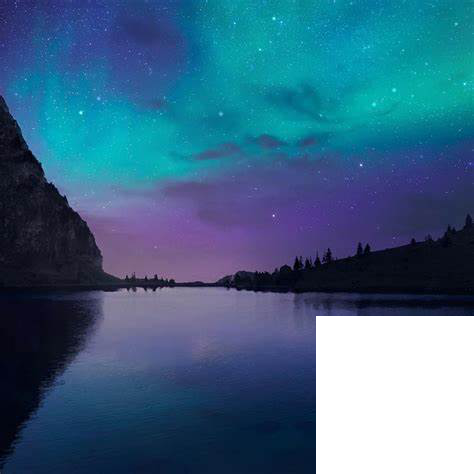

In [292]:
frames[-1]

In [22]:
from PIL import Image
def save_gif(list_grid,image,save_name):
    mapping_dict = { 1 : [0,0],
    2 : [1,0],
    3 : [2,0],
    4 : [0,1],
    5 : [1,1],
    6 : [2,1],
    7 : [0,2],
    8 : [1,2],
    0 : [2,2]}
    # Load the image
    image = Image.open(image)

    tile_width = image.width // 3
    tile_height = image.height // 3

    tiles = []

    for row in range(3):
        for col in range(3):
            left = col * tile_width
            top = row * tile_height
            right = left + tile_width
            bottom = top + tile_height
            tile = image.crop((left, top, right, bottom))
            tiles.append(tile)


    frames = []
    for i in range(len(list_grid)):
        tiles2=[]
        frame = Image.new('RGB', image.size, color='white')
        for row in range(3):
            for col in range(3):
                if list_grid[i][row][col]==0:
                    tiles2.append(8)
                else:
                    tiles2.append(list_grid[i][row][col]-1)
        j=1
        for pos in tiles2:
            if pos != 8:
                frame.paste(tiles[pos], (mapping_dict[j%9][0]* tile_width, mapping_dict[j%9][1]* tile_height))
            j+=1
        frames.append(frame)

    frames[0].save(save_name+'.gif', save_all=True, append_images=frames[1:], duration=500, loop=0)

In [23]:
save_gif(game.all_grid,'image.png','test')    